# ECE 4194 Final Project. Spring 2019. The Ohio State University
## Authors: Michael Wharton.124, Alex Whitman.97, Benji Justice.251

This notebook is to train a resnet model to classify the actions specified in the dataset linked below.

Dataset: http://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions



### Define packages to autoreload

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
%aimport models.resnet
%aimport utils.data_helpers

### Import necessary modules

In [3]:
# torch modules
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# import model
from models.resnet import resnet18, resnet34

# data functions
from utils.data_helpers import load_data
from utils.data_helpers import har_dataset

# classics
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

### Define model hyper parameters

In [4]:
# what percentage of data should be used for training 
split = 0.7

num_epoch = 6000
lr = 0.5e-7
batch_size = 10
num_workers = 1

### Handle GPU

In [5]:
use_gpu=True
if torch.cuda.is_available() and use_gpu:
    dtype = torch.cuda.FloatTensor
    ltype = torch.cuda.LongTensor
    
    device = torch.device('cuda:0')
    
else:
    dtype = torch.FloatTensor
    ltype = torch.LongTensor
    device = torch.device('cpu')
    
print('device {} dtype {}'.format(device, dtype))

device cuda:0 dtype <class 'torch.cuda.FloatTensor'>


### Load data

In [6]:
# ...
train_data, train_labels, test_data, test_labels = load_data()


In [7]:
# convert to torch Tensor objects
train_data = torch.Tensor(train_data)
train_labels = torch.Tensor(train_labels)

test_data = torch.Tensor(test_data)
test_labels = torch.Tensor(test_labels)

In [8]:
print(train_data.shape)
print(test_data.shape)

print(train_labels.shape)
print(test_labels.shape)

torch.Size([873, 2048, 6])
torch.Size([341, 2048, 6])
torch.Size([873])
torch.Size([341])


In [9]:
best_acc_list = []

drop_prob_list = [0] #, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.0]
num_tests = len(drop_prob_list)

results = np.zeros(shape=(num_tests, num_epoch, 2, 2))

### Train !

In [11]:
continue_ = True # if training same more for more epochs
# opt.lr=1e-7
for test_num, drop_prob in enumerate(drop_prob_list):
    print('\ndrop prob {}'.format(drop_prob))
  
    # create model

    model = resnet18(drop_prob=drop_prob)
    model = model.to(device)

    # Handle loss function and optimizer
    crit = torch.nn.CrossEntropyLoss()
    opt  = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)

    # used to track the loss and accuracy over each epoch
    stats = np.zeros(shape=(num_epoch, 2, 2))


        
    # indices
    train = 0
    test  = 1
    acc   = 0
    loss  = 1

    # handle training and testing dataloaders
    train_ds = har_dataset(train_data, train_labels)
    train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers,shuffle=True)
    train_batches = train_dl.__len__()

    test_ds = har_dataset(test_data, test_labels)
    test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers)
    test_batches = test_dl.__len__()

    best_acc = 0
    tstart = time.time()
    for epoch in range(num_epoch):

        # switch to train mode
        model.train()

        # track accuracy
        total = 0
        correct = 0

        # track loss
        tr_loss = []
        for batch, data in enumerate(train_dl):
            print('Training Iteration: {0:4d} of {1:4d}'.format(batch+1, train_batches), end='\r')

            # extract signal and labels
            signals, labels = data

            ## Normalize?

            # transpose signals (batch_size, length, channels) -> (batch_size, channels, length)
            signals = signals.transpose(1,2)

            # move data to device
            signals = signals.to(device)
            labels = labels.type(ltype).to(device)

            # process signals
            out = model(signals)

            # hard decision for classification
            _, pred = torch.max(out.data, 1)

            # compute accuracy
            total   += labels.size(0)
            correct += (pred == labels).sum().item()

            # compute loss
            b_loss = crit(out, labels)
            opt.zero_grad()
            b_loss.backward()
            opt.step()

            tr_loss.append(b_loss.item())

        # epoch training stats
        tr_accuracy = 100. * correct / total
        tr_loss = np.mean(tr_loss)

        # evaluate model
        model.eval()

        ts_loss = []
        total   = 0
        correct = 0
        with torch.no_grad():
            for batch, data in enumerate(test_dl):
                print('Testing  Iteration:: {0:4d} or {1:4d}'.format(batch+1, test_batches), end='\r')

                # extract signals and labels
                signals, labels = data

                # transpose signals (batch_size, length, channels) -> (batch_size, channels, length)
                signals = signals.transpose(1,2)

                # move data to device
                signals = signals.to(device)
                labels = labels.type(ltype).to(device)

                # process signals
                out = model(signals)

                # hard decision for classification
                _, pred = torch.max(out.data, 1)

                # compute accuracy
                total   += labels.size(0)
                correct += (pred == labels).sum().item()

                # compute loss
                b_loss = crit(out, labels)

                ts_loss.append(b_loss.item())
    
        # epoch testing stats
        ts_accuracy = 100. * correct / total
        ts_loss = np.mean(ts_loss)

        string=''
        if ts_accuracy > best_acc:
            best_acc = ts_accuracy
            string = 'save!'
            
        # save stats to plot later
        stats[epoch, train, loss ] = tr_loss
        stats[epoch, train, acc  ] = tr_accuracy
        stats[epoch, test,  loss ] = ts_loss
        stats[epoch, test,  acc  ] = ts_accuracy

        t1 = time.time() - tstart
        print('Epoch: {0:4d} Tr loss: {1:.3f} Ts loss: {2:.3f} Tr Accuracy: {3:3.2f}% Ts Accuracy: {4:3.2f}% Time: {5:4.2f}s p={6:0.2f} {7:s}'.format(
                epoch+1,      tr_loss,         ts_loss,         tr_accuracy,           ts_accuracy, t1, drop_prob, string))
    
    # save results of each model to plot
    results[test_num,:,:,:] = stats
    best_acc_list.append(best_acc)
    
np.savez('dropout_test',res=results)


drop prob 0
Epoch:    1 Tr loss: 2.415 Ts loss: 2.452 Tr Accuracy: 17.87% Ts Accuracy: 14.96% Time: 2.34s p=0.00 save!
Epoch:    2 Tr loss: 2.376 Ts loss: 2.434 Tr Accuracy: 17.98% Ts Accuracy: 13.49% Time: 4.02s p=0.00 
Epoch:    3 Tr loss: 2.328 Ts loss: 2.378 Tr Accuracy: 19.82% Ts Accuracy: 14.96% Time: 5.61s p=0.00 
Epoch:    4 Tr loss: 2.309 Ts loss: 2.388 Tr Accuracy: 19.93% Ts Accuracy: 15.54% Time: 7.23s p=0.00 save!
Epoch:    5 Tr loss: 2.313 Ts loss: 2.365 Tr Accuracy: 18.33% Ts Accuracy: 14.66% Time: 8.84s p=0.00 
Epoch:    6 Tr loss: 2.282 Ts loss: 2.336 Tr Accuracy: 20.62% Ts Accuracy: 14.66% Time: 10.47s p=0.00 
Epoch:    7 Tr loss: 2.258 Ts loss: 2.322 Tr Accuracy: 19.70% Ts Accuracy: 16.42% Time: 12.07s p=0.00 save!
Epoch:    8 Tr loss: 2.243 Ts loss: 2.304 Tr Accuracy: 21.42% Ts Accuracy: 17.30% Time: 13.87s p=0.00 save!
Epoch:    9 Tr loss: 2.228 Ts loss: 2.283 Tr Accuracy: 21.65% Ts Accuracy: 16.13% Time: 15.54s p=0.00 
Epoch:   10 Tr loss: 2.229 Ts loss: 2.266 Tr 

Epoch:   79 Tr loss: 1.636 Ts loss: 1.687 Tr Accuracy: 48.68% Ts Accuracy: 41.35% Time: 132.72s p=0.00 
Epoch:   80 Tr loss: 1.619 Ts loss: 1.693 Tr Accuracy: 46.28% Ts Accuracy: 40.18% Time: 134.32s p=0.00 
Epoch:   81 Tr loss: 1.607 Ts loss: 1.692 Tr Accuracy: 48.68% Ts Accuracy: 42.82% Time: 136.02s p=0.00 
Epoch:   82 Tr loss: 1.618 Ts loss: 1.679 Tr Accuracy: 49.14% Ts Accuracy: 39.30% Time: 137.72s p=0.00 
Epoch:   83 Tr loss: 1.612 Ts loss: 1.658 Tr Accuracy: 47.77% Ts Accuracy: 42.82% Time: 139.45s p=0.00 
Epoch:   84 Tr loss: 1.597 Ts loss: 1.653 Tr Accuracy: 48.57% Ts Accuracy: 44.87% Time: 141.14s p=0.00 save!
Epoch:   85 Tr loss: 1.583 Ts loss: 1.652 Tr Accuracy: 48.57% Ts Accuracy: 42.52% Time: 142.84s p=0.00 
Epoch:   86 Tr loss: 1.624 Ts loss: 1.652 Tr Accuracy: 47.54% Ts Accuracy: 39.59% Time: 144.56s p=0.00 
Epoch:   87 Tr loss: 1.587 Ts loss: 1.666 Tr Accuracy: 47.08% Ts Accuracy: 44.87% Time: 146.25s p=0.00 
Epoch:   88 Tr loss: 1.593 Ts loss: 1.650 Tr Accuracy: 48.9

Epoch:  158 Tr loss: 1.289 Ts loss: 1.344 Tr Accuracy: 63.69% Ts Accuracy: 58.06% Time: 260.34s p=0.00 
Epoch:  159 Tr loss: 1.282 Ts loss: 1.370 Tr Accuracy: 63.92% Ts Accuracy: 56.89% Time: 261.95s p=0.00 
Epoch:  160 Tr loss: 1.276 Ts loss: 1.326 Tr Accuracy: 62.20% Ts Accuracy: 57.48% Time: 263.50s p=0.00 
Epoch:  161 Tr loss: 1.288 Ts loss: 1.345 Tr Accuracy: 62.66% Ts Accuracy: 57.18% Time: 265.07s p=0.00 
Epoch:  162 Tr loss: 1.298 Ts loss: 1.368 Tr Accuracy: 60.37% Ts Accuracy: 57.18% Time: 266.76s p=0.00 
Epoch:  163 Tr loss: 1.294 Ts loss: 1.356 Tr Accuracy: 63.12% Ts Accuracy: 57.18% Time: 268.34s p=0.00 
Epoch:  164 Tr loss: 1.268 Ts loss: 1.334 Tr Accuracy: 63.46% Ts Accuracy: 56.01% Time: 269.91s p=0.00 
Epoch:  165 Tr loss: 1.274 Ts loss: 1.350 Tr Accuracy: 62.08% Ts Accuracy: 56.60% Time: 271.47s p=0.00 
Epoch:  166 Tr loss: 1.289 Ts loss: 1.334 Tr Accuracy: 60.94% Ts Accuracy: 58.94% Time: 273.06s p=0.00 save!
Epoch:  167 Tr loss: 1.267 Ts loss: 1.348 Tr Accuracy: 63.9

Epoch:  236 Tr loss: 1.071 Ts loss: 1.133 Tr Accuracy: 70.10% Ts Accuracy: 65.98% Time: 385.75s p=0.00 
Epoch:  237 Tr loss: 1.078 Ts loss: 1.129 Tr Accuracy: 70.22% Ts Accuracy: 64.52% Time: 387.30s p=0.00 
Epoch:  238 Tr loss: 1.071 Ts loss: 1.174 Tr Accuracy: 70.45% Ts Accuracy: 62.46% Time: 388.92s p=0.00 
Epoch:  239 Tr loss: 1.074 Ts loss: 1.151 Tr Accuracy: 70.10% Ts Accuracy: 61.29% Time: 390.55s p=0.00 
Epoch:  240 Tr loss: 1.060 Ts loss: 1.147 Tr Accuracy: 71.59% Ts Accuracy: 64.81% Time: 392.18s p=0.00 
Epoch:  241 Tr loss: 1.066 Ts loss: 1.123 Tr Accuracy: 69.07% Ts Accuracy: 64.52% Time: 393.75s p=0.00 
Epoch:  242 Tr loss: 1.058 Ts loss: 1.166 Tr Accuracy: 71.25% Ts Accuracy: 63.05% Time: 395.40s p=0.00 
Epoch:  243 Tr loss: 1.039 Ts loss: 1.100 Tr Accuracy: 72.85% Ts Accuracy: 66.57% Time: 396.97s p=0.00 
Epoch:  244 Tr loss: 1.058 Ts loss: 1.109 Tr Accuracy: 70.56% Ts Accuracy: 65.10% Time: 398.52s p=0.00 
Epoch:  245 Tr loss: 1.060 Ts loss: 1.118 Tr Accuracy: 71.48% Ts

Epoch:  315 Tr loss: 0.926 Ts loss: 0.953 Tr Accuracy: 73.31% Ts Accuracy: 68.91% Time: 514.13s p=0.00 
Epoch:  316 Tr loss: 0.922 Ts loss: 0.957 Tr Accuracy: 74.11% Ts Accuracy: 68.62% Time: 515.87s p=0.00 
Epoch:  317 Tr loss: 0.899 Ts loss: 0.993 Tr Accuracy: 76.98% Ts Accuracy: 68.91% Time: 517.53s p=0.00 
Epoch:  318 Tr loss: 0.918 Ts loss: 0.956 Tr Accuracy: 74.91% Ts Accuracy: 69.79% Time: 519.19s p=0.00 
Epoch:  319 Tr loss: 0.918 Ts loss: 0.968 Tr Accuracy: 75.49% Ts Accuracy: 70.67% Time: 520.97s p=0.00 save!
Epoch:  320 Tr loss: 0.909 Ts loss: 0.957 Tr Accuracy: 74.23% Ts Accuracy: 69.21% Time: 522.62s p=0.00 
Epoch:  321 Tr loss: 0.897 Ts loss: 0.943 Tr Accuracy: 76.29% Ts Accuracy: 69.79% Time: 524.26s p=0.00 
Epoch:  322 Tr loss: 0.893 Ts loss: 0.969 Tr Accuracy: 74.80% Ts Accuracy: 70.67% Time: 526.00s p=0.00 
Epoch:  323 Tr loss: 0.881 Ts loss: 0.983 Tr Accuracy: 77.55% Ts Accuracy: 69.50% Time: 527.66s p=0.00 
Epoch:  324 Tr loss: 0.898 Ts loss: 0.968 Tr Accuracy: 76.6

Epoch:  394 Tr loss: 0.788 Ts loss: 0.887 Tr Accuracy: 78.47% Ts Accuracy: 71.26% Time: 646.72s p=0.00 
Epoch:  395 Tr loss: 0.799 Ts loss: 0.883 Tr Accuracy: 78.01% Ts Accuracy: 70.97% Time: 648.30s p=0.00 
Epoch:  396 Tr loss: 0.798 Ts loss: 0.855 Tr Accuracy: 76.86% Ts Accuracy: 71.85% Time: 649.90s p=0.00 
Epoch:  397 Tr loss: 0.776 Ts loss: 0.871 Tr Accuracy: 79.15% Ts Accuracy: 71.26% Time: 651.56s p=0.00 
Epoch:  398 Tr loss: 0.789 Ts loss: 0.876 Tr Accuracy: 77.66% Ts Accuracy: 70.67% Time: 653.34s p=0.00 
Epoch:  399 Tr loss: 0.792 Ts loss: 0.884 Tr Accuracy: 78.35% Ts Accuracy: 71.85% Time: 655.00s p=0.00 
Epoch:  400 Tr loss: 0.778 Ts loss: 0.882 Tr Accuracy: 79.61% Ts Accuracy: 70.67% Time: 656.59s p=0.00 
Epoch:  401 Tr loss: 0.774 Ts loss: 0.897 Tr Accuracy: 80.18% Ts Accuracy: 70.97% Time: 658.34s p=0.00 
Epoch:  402 Tr loss: 0.781 Ts loss: 0.922 Tr Accuracy: 80.99% Ts Accuracy: 71.26% Time: 660.03s p=0.00 
Epoch:  403 Tr loss: 0.782 Ts loss: 0.889 Tr Accuracy: 77.78% Ts

Epoch:  473 Tr loss: 0.700 Ts loss: 0.777 Tr Accuracy: 81.56% Ts Accuracy: 73.31% Time: 777.85s p=0.00 
Epoch:  474 Tr loss: 0.699 Ts loss: 0.779 Tr Accuracy: 81.44% Ts Accuracy: 74.49% Time: 779.42s p=0.00 
Epoch:  475 Tr loss: 0.698 Ts loss: 0.782 Tr Accuracy: 79.50% Ts Accuracy: 73.90% Time: 781.02s p=0.00 
Epoch:  476 Tr loss: 0.701 Ts loss: 0.808 Tr Accuracy: 80.99% Ts Accuracy: 73.02% Time: 782.57s p=0.00 
Epoch:  477 Tr loss: 0.713 Ts loss: 0.796 Tr Accuracy: 80.07% Ts Accuracy: 74.78% Time: 784.13s p=0.00 
Epoch:  478 Tr loss: 0.703 Ts loss: 0.792 Tr Accuracy: 80.53% Ts Accuracy: 73.90% Time: 785.70s p=0.00 
Epoch:  479 Tr loss: 0.702 Ts loss: 0.768 Tr Accuracy: 80.18% Ts Accuracy: 75.95% Time: 787.26s p=0.00 save!
Epoch:  480 Tr loss: 0.690 Ts loss: 0.767 Tr Accuracy: 80.87% Ts Accuracy: 75.66% Time: 788.87s p=0.00 
Epoch:  481 Tr loss: 0.690 Ts loss: 0.777 Tr Accuracy: 81.10% Ts Accuracy: 74.49% Time: 790.42s p=0.00 
Epoch:  482 Tr loss: 0.679 Ts loss: 0.789 Tr Accuracy: 81.4

Epoch:  552 Tr loss: 0.623 Ts loss: 0.732 Tr Accuracy: 84.42% Ts Accuracy: 75.95% Time: 902.76s p=0.00 
Epoch:  553 Tr loss: 0.627 Ts loss: 0.718 Tr Accuracy: 81.79% Ts Accuracy: 76.25% Time: 904.32s p=0.00 
Epoch:  554 Tr loss: 0.630 Ts loss: 0.725 Tr Accuracy: 84.65% Ts Accuracy: 76.83% Time: 905.92s p=0.00 
Epoch:  555 Tr loss: 0.624 Ts loss: 0.716 Tr Accuracy: 82.36% Ts Accuracy: 77.42% Time: 907.51s p=0.00 
Epoch:  556 Tr loss: 0.608 Ts loss: 0.708 Tr Accuracy: 84.88% Ts Accuracy: 76.25% Time: 909.07s p=0.00 
Epoch:  557 Tr loss: 0.625 Ts loss: 0.712 Tr Accuracy: 83.85% Ts Accuracy: 77.71% Time: 910.64s p=0.00 save!
Epoch:  558 Tr loss: 0.627 Ts loss: 0.735 Tr Accuracy: 84.19% Ts Accuracy: 77.13% Time: 912.21s p=0.00 
Epoch:  559 Tr loss: 0.613 Ts loss: 0.707 Tr Accuracy: 84.65% Ts Accuracy: 75.95% Time: 913.77s p=0.00 
Epoch:  560 Tr loss: 0.617 Ts loss: 0.745 Tr Accuracy: 82.36% Ts Accuracy: 76.25% Time: 915.33s p=0.00 
Epoch:  561 Tr loss: 0.630 Ts loss: 0.710 Tr Accuracy: 82.0

Epoch:  631 Tr loss: 0.566 Ts loss: 0.680 Tr Accuracy: 84.77% Ts Accuracy: 78.30% Time: 1028.43s p=0.00 
Epoch:  632 Tr loss: 0.582 Ts loss: 0.699 Tr Accuracy: 85.22% Ts Accuracy: 77.42% Time: 1030.00s p=0.00 
Epoch:  633 Tr loss: 0.560 Ts loss: 0.706 Tr Accuracy: 85.22% Ts Accuracy: 75.95% Time: 1031.55s p=0.00 
Epoch:  634 Tr loss: 0.568 Ts loss: 0.664 Tr Accuracy: 85.34% Ts Accuracy: 79.77% Time: 1033.09s p=0.00 save!
Epoch:  635 Tr loss: 0.578 Ts loss: 0.675 Tr Accuracy: 83.96% Ts Accuracy: 78.30% Time: 1034.66s p=0.00 
Epoch:  636 Tr loss: 0.567 Ts loss: 0.650 Tr Accuracy: 85.91% Ts Accuracy: 77.71% Time: 1036.31s p=0.00 
Epoch:  637 Tr loss: 0.561 Ts loss: 0.664 Tr Accuracy: 85.45% Ts Accuracy: 78.59% Time: 1037.88s p=0.00 
Epoch:  638 Tr loss: 0.558 Ts loss: 0.679 Tr Accuracy: 84.88% Ts Accuracy: 79.47% Time: 1039.54s p=0.00 
Epoch:  639 Tr loss: 0.569 Ts loss: 0.667 Tr Accuracy: 85.45% Ts Accuracy: 76.83% Time: 1041.21s p=0.00 
Epoch:  640 Tr loss: 0.552 Ts loss: 0.659 Tr Accur

Epoch:  709 Tr loss: 0.530 Ts loss: 0.608 Tr Accuracy: 85.91% Ts Accuracy: 80.65% Time: 1151.47s p=0.00 
Epoch:  710 Tr loss: 0.522 Ts loss: 0.629 Tr Accuracy: 86.37% Ts Accuracy: 79.18% Time: 1153.23s p=0.00 
Epoch:  711 Tr loss: 0.523 Ts loss: 0.627 Tr Accuracy: 86.60% Ts Accuracy: 80.06% Time: 1154.81s p=0.00 
Epoch:  712 Tr loss: 0.518 Ts loss: 0.628 Tr Accuracy: 85.68% Ts Accuracy: 82.40% Time: 1156.38s p=0.00 save!
Epoch:  713 Tr loss: 0.501 Ts loss: 0.638 Tr Accuracy: 87.06% Ts Accuracy: 79.77% Time: 1158.02s p=0.00 
Epoch:  714 Tr loss: 0.520 Ts loss: 0.661 Tr Accuracy: 86.71% Ts Accuracy: 80.06% Time: 1159.74s p=0.00 
Epoch:  715 Tr loss: 0.512 Ts loss: 0.654 Tr Accuracy: 86.83% Ts Accuracy: 79.77% Time: 1161.30s p=0.00 
Epoch:  716 Tr loss: 0.514 Ts loss: 0.626 Tr Accuracy: 86.48% Ts Accuracy: 79.47% Time: 1162.85s p=0.00 
Epoch:  717 Tr loss: 0.537 Ts loss: 0.628 Tr Accuracy: 86.37% Ts Accuracy: 80.65% Time: 1164.39s p=0.00 
Epoch:  718 Tr loss: 0.521 Ts loss: 0.639 Tr Accur

Epoch:  787 Tr loss: 0.478 Ts loss: 0.608 Tr Accuracy: 87.17% Ts Accuracy: 81.23% Time: 1276.55s p=0.00 
Epoch:  788 Tr loss: 0.474 Ts loss: 0.622 Tr Accuracy: 87.40% Ts Accuracy: 80.94% Time: 1278.10s p=0.00 
Epoch:  789 Tr loss: 0.472 Ts loss: 0.616 Tr Accuracy: 89.12% Ts Accuracy: 80.65% Time: 1279.65s p=0.00 
Epoch:  790 Tr loss: 0.462 Ts loss: 0.581 Tr Accuracy: 89.35% Ts Accuracy: 81.23% Time: 1281.21s p=0.00 
Epoch:  791 Tr loss: 0.477 Ts loss: 0.605 Tr Accuracy: 86.83% Ts Accuracy: 80.94% Time: 1282.79s p=0.00 
Epoch:  792 Tr loss: 0.472 Ts loss: 0.604 Tr Accuracy: 87.29% Ts Accuracy: 80.35% Time: 1284.35s p=0.00 
Epoch:  793 Tr loss: 0.501 Ts loss: 0.611 Tr Accuracy: 86.71% Ts Accuracy: 80.35% Time: 1285.96s p=0.00 
Epoch:  794 Tr loss: 0.471 Ts loss: 0.595 Tr Accuracy: 87.17% Ts Accuracy: 80.94% Time: 1287.72s p=0.00 
Epoch:  795 Tr loss: 0.496 Ts loss: 0.579 Tr Accuracy: 87.40% Ts Accuracy: 81.82% Time: 1289.33s p=0.00 
Epoch:  796 Tr loss: 0.469 Ts loss: 0.578 Tr Accuracy: 

Epoch:  865 Tr loss: 0.447 Ts loss: 0.542 Tr Accuracy: 88.66% Ts Accuracy: 82.99% Time: 1401.44s p=0.00 
Epoch:  866 Tr loss: 0.442 Ts loss: 0.559 Tr Accuracy: 89.81% Ts Accuracy: 81.52% Time: 1403.00s p=0.00 
Epoch:  867 Tr loss: 0.424 Ts loss: 0.582 Tr Accuracy: 89.46% Ts Accuracy: 82.40% Time: 1404.62s p=0.00 
Epoch:  868 Tr loss: 0.439 Ts loss: 0.560 Tr Accuracy: 88.09% Ts Accuracy: 82.40% Time: 1406.29s p=0.00 
Epoch:  869 Tr loss: 0.470 Ts loss: 0.570 Tr Accuracy: 87.97% Ts Accuracy: 82.70% Time: 1407.96s p=0.00 
Epoch:  870 Tr loss: 0.442 Ts loss: 0.558 Tr Accuracy: 89.35% Ts Accuracy: 81.82% Time: 1409.61s p=0.00 
Epoch:  871 Tr loss: 0.457 Ts loss: 0.582 Tr Accuracy: 89.81% Ts Accuracy: 83.28% Time: 1411.23s p=0.00 
Epoch:  872 Tr loss: 0.441 Ts loss: 0.568 Tr Accuracy: 89.23% Ts Accuracy: 83.28% Time: 1412.80s p=0.00 
Epoch:  873 Tr loss: 0.437 Ts loss: 0.555 Tr Accuracy: 88.32% Ts Accuracy: 82.40% Time: 1414.38s p=0.00 
Epoch:  874 Tr loss: 0.440 Ts loss: 0.577 Tr Accuracy: 

Epoch:  943 Tr loss: 0.401 Ts loss: 0.552 Tr Accuracy: 90.72% Ts Accuracy: 81.52% Time: 1529.36s p=0.00 
Epoch:  944 Tr loss: 0.399 Ts loss: 0.538 Tr Accuracy: 89.92% Ts Accuracy: 84.16% Time: 1530.97s p=0.00 
Epoch:  945 Tr loss: 0.412 Ts loss: 0.525 Tr Accuracy: 89.81% Ts Accuracy: 82.99% Time: 1532.62s p=0.00 
Epoch:  946 Tr loss: 0.393 Ts loss: 0.550 Tr Accuracy: 90.15% Ts Accuracy: 82.70% Time: 1534.15s p=0.00 
Epoch:  947 Tr loss: 0.407 Ts loss: 0.539 Tr Accuracy: 89.69% Ts Accuracy: 83.87% Time: 1535.71s p=0.00 
Epoch:  948 Tr loss: 0.395 Ts loss: 0.530 Tr Accuracy: 90.72% Ts Accuracy: 83.58% Time: 1537.38s p=0.00 
Epoch:  949 Tr loss: 0.394 Ts loss: 0.537 Tr Accuracy: 90.72% Ts Accuracy: 82.40% Time: 1538.95s p=0.00 
Epoch:  950 Tr loss: 0.416 Ts loss: 0.521 Tr Accuracy: 90.26% Ts Accuracy: 83.58% Time: 1540.52s p=0.00 
Epoch:  951 Tr loss: 0.381 Ts loss: 0.548 Tr Accuracy: 91.41% Ts Accuracy: 82.40% Time: 1542.07s p=0.00 
Epoch:  952 Tr loss: 0.407 Ts loss: 0.539 Tr Accuracy: 

Epoch: 1021 Tr loss: 0.383 Ts loss: 0.500 Tr Accuracy: 90.95% Ts Accuracy: 85.34% Time: 1656.23s p=0.00 save!
Epoch: 1022 Tr loss: 0.379 Ts loss: 0.523 Tr Accuracy: 91.87% Ts Accuracy: 83.87% Time: 1658.06s p=0.00 
Epoch: 1023 Tr loss: 0.391 Ts loss: 0.502 Tr Accuracy: 89.92% Ts Accuracy: 83.58% Time: 1659.72s p=0.00 
Epoch: 1024 Tr loss: 0.375 Ts loss: 0.518 Tr Accuracy: 92.10% Ts Accuracy: 82.99% Time: 1661.53s p=0.00 
Epoch: 1025 Tr loss: 0.360 Ts loss: 0.517 Tr Accuracy: 90.84% Ts Accuracy: 82.99% Time: 1663.32s p=0.00 
Epoch: 1026 Tr loss: 0.365 Ts loss: 0.521 Tr Accuracy: 92.21% Ts Accuracy: 81.23% Time: 1665.05s p=0.00 
Epoch: 1027 Tr loss: 0.393 Ts loss: 0.514 Tr Accuracy: 89.69% Ts Accuracy: 85.04% Time: 1666.63s p=0.00 
Epoch: 1028 Tr loss: 0.394 Ts loss: 0.506 Tr Accuracy: 89.46% Ts Accuracy: 83.58% Time: 1668.20s p=0.00 
Epoch: 1029 Tr loss: 0.373 Ts loss: 0.527 Tr Accuracy: 91.75% Ts Accuracy: 82.99% Time: 1669.91s p=0.00 
Epoch: 1030 Tr loss: 0.366 Ts loss: 0.522 Tr Accur

Epoch: 1099 Tr loss: 0.342 Ts loss: 0.496 Tr Accuracy: 92.78% Ts Accuracy: 83.58% Time: 1786.56s p=0.00 
Epoch: 1100 Tr loss: 0.346 Ts loss: 0.490 Tr Accuracy: 91.41% Ts Accuracy: 83.28% Time: 1788.26s p=0.00 
Epoch: 1101 Tr loss: 0.353 Ts loss: 0.486 Tr Accuracy: 90.95% Ts Accuracy: 84.16% Time: 1789.89s p=0.00 
Epoch: 1102 Tr loss: 0.342 Ts loss: 0.492 Tr Accuracy: 92.10% Ts Accuracy: 84.16% Time: 1791.46s p=0.00 
Epoch: 1103 Tr loss: 0.347 Ts loss: 0.494 Tr Accuracy: 91.98% Ts Accuracy: 83.87% Time: 1793.08s p=0.00 
Epoch: 1104 Tr loss: 0.355 Ts loss: 0.487 Tr Accuracy: 91.18% Ts Accuracy: 82.99% Time: 1794.73s p=0.00 
Epoch: 1105 Tr loss: 0.364 Ts loss: 0.482 Tr Accuracy: 91.41% Ts Accuracy: 85.63% Time: 1796.30s p=0.00 
Epoch: 1106 Tr loss: 0.356 Ts loss: 0.497 Tr Accuracy: 91.52% Ts Accuracy: 83.87% Time: 1797.94s p=0.00 
Epoch: 1107 Tr loss: 0.341 Ts loss: 0.475 Tr Accuracy: 91.87% Ts Accuracy: 83.58% Time: 1799.72s p=0.00 
Epoch: 1108 Tr loss: 0.357 Ts loss: 0.509 Tr Accuracy: 

Epoch: 1177 Tr loss: 0.328 Ts loss: 0.465 Tr Accuracy: 91.87% Ts Accuracy: 84.75% Time: 1913.44s p=0.00 
Epoch: 1178 Tr loss: 0.316 Ts loss: 0.477 Tr Accuracy: 93.24% Ts Accuracy: 84.16% Time: 1915.01s p=0.00 
Epoch: 1179 Tr loss: 0.317 Ts loss: 0.481 Tr Accuracy: 93.70% Ts Accuracy: 83.58% Time: 1916.58s p=0.00 
Epoch: 1180 Tr loss: 0.317 Ts loss: 0.480 Tr Accuracy: 92.21% Ts Accuracy: 84.75% Time: 1918.24s p=0.00 
Epoch: 1181 Tr loss: 0.345 Ts loss: 0.464 Tr Accuracy: 91.41% Ts Accuracy: 85.63% Time: 1919.82s p=0.00 
Epoch: 1182 Tr loss: 0.325 Ts loss: 0.475 Tr Accuracy: 92.33% Ts Accuracy: 83.58% Time: 1921.51s p=0.00 
Epoch: 1183 Tr loss: 0.337 Ts loss: 0.475 Tr Accuracy: 91.98% Ts Accuracy: 84.75% Time: 1923.07s p=0.00 
Epoch: 1184 Tr loss: 0.310 Ts loss: 0.475 Tr Accuracy: 93.47% Ts Accuracy: 84.46% Time: 1924.64s p=0.00 
Epoch: 1185 Tr loss: 0.324 Ts loss: 0.474 Tr Accuracy: 92.44% Ts Accuracy: 83.28% Time: 1926.20s p=0.00 
Epoch: 1186 Tr loss: 0.317 Ts loss: 0.464 Tr Accuracy: 

Epoch: 1255 Tr loss: 0.300 Ts loss: 0.462 Tr Accuracy: 93.70% Ts Accuracy: 85.92% Time: 2043.26s p=0.00 
Epoch: 1256 Tr loss: 0.319 Ts loss: 0.467 Tr Accuracy: 92.44% Ts Accuracy: 85.34% Time: 2044.87s p=0.00 
Epoch: 1257 Tr loss: 0.314 Ts loss: 0.459 Tr Accuracy: 93.01% Ts Accuracy: 86.22% Time: 2046.49s p=0.00 
Epoch: 1258 Tr loss: 0.316 Ts loss: 0.441 Tr Accuracy: 91.98% Ts Accuracy: 85.63% Time: 2048.08s p=0.00 
Epoch: 1259 Tr loss: 0.305 Ts loss: 0.444 Tr Accuracy: 93.36% Ts Accuracy: 85.63% Time: 2049.71s p=0.00 
Epoch: 1260 Tr loss: 0.309 Ts loss: 0.462 Tr Accuracy: 92.78% Ts Accuracy: 86.51% Time: 2051.29s p=0.00 
Epoch: 1261 Tr loss: 0.303 Ts loss: 0.442 Tr Accuracy: 93.24% Ts Accuracy: 84.75% Time: 2052.97s p=0.00 
Epoch: 1262 Tr loss: 0.302 Ts loss: 0.444 Tr Accuracy: 93.13% Ts Accuracy: 85.04% Time: 2054.52s p=0.00 
Epoch: 1263 Tr loss: 0.307 Ts loss: 0.465 Tr Accuracy: 92.90% Ts Accuracy: 84.75% Time: 2056.08s p=0.00 
Epoch: 1264 Tr loss: 0.305 Ts loss: 0.445 Tr Accuracy: 

Epoch: 1333 Tr loss: 0.292 Ts loss: 0.439 Tr Accuracy: 92.67% Ts Accuracy: 85.34% Time: 2171.09s p=0.00 
Epoch: 1334 Tr loss: 0.279 Ts loss: 0.427 Tr Accuracy: 93.47% Ts Accuracy: 85.34% Time: 2172.75s p=0.00 
Epoch: 1335 Tr loss: 0.282 Ts loss: 0.442 Tr Accuracy: 94.27% Ts Accuracy: 85.63% Time: 2174.33s p=0.00 
Epoch: 1336 Tr loss: 0.300 Ts loss: 0.453 Tr Accuracy: 91.98% Ts Accuracy: 85.34% Time: 2176.03s p=0.00 
Epoch: 1337 Tr loss: 0.284 Ts loss: 0.433 Tr Accuracy: 93.81% Ts Accuracy: 85.34% Time: 2177.63s p=0.00 
Epoch: 1338 Tr loss: 0.288 Ts loss: 0.429 Tr Accuracy: 92.55% Ts Accuracy: 84.75% Time: 2179.21s p=0.00 
Epoch: 1339 Tr loss: 0.284 Ts loss: 0.423 Tr Accuracy: 93.70% Ts Accuracy: 85.34% Time: 2180.78s p=0.00 
Epoch: 1340 Tr loss: 0.285 Ts loss: 0.437 Tr Accuracy: 93.81% Ts Accuracy: 84.46% Time: 2182.34s p=0.00 
Epoch: 1341 Tr loss: 0.294 Ts loss: 0.441 Tr Accuracy: 92.44% Ts Accuracy: 84.16% Time: 2183.92s p=0.00 
Epoch: 1342 Tr loss: 0.301 Ts loss: 0.430 Tr Accuracy: 

Epoch: 1411 Tr loss: 0.273 Ts loss: 0.419 Tr Accuracy: 94.04% Ts Accuracy: 86.51% Time: 2298.83s p=0.00 
Epoch: 1412 Tr loss: 0.269 Ts loss: 0.429 Tr Accuracy: 94.62% Ts Accuracy: 87.39% Time: 2300.52s p=0.00 save!
Epoch: 1413 Tr loss: 0.275 Ts loss: 0.425 Tr Accuracy: 94.27% Ts Accuracy: 85.34% Time: 2302.27s p=0.00 
Epoch: 1414 Tr loss: 0.279 Ts loss: 0.423 Tr Accuracy: 92.90% Ts Accuracy: 85.63% Time: 2303.97s p=0.00 
Epoch: 1415 Tr loss: 0.277 Ts loss: 0.423 Tr Accuracy: 93.13% Ts Accuracy: 86.22% Time: 2305.68s p=0.00 
Epoch: 1416 Tr loss: 0.268 Ts loss: 0.428 Tr Accuracy: 94.27% Ts Accuracy: 84.75% Time: 2307.29s p=0.00 
Epoch: 1417 Tr loss: 0.269 Ts loss: 0.433 Tr Accuracy: 92.90% Ts Accuracy: 85.92% Time: 2308.85s p=0.00 
Epoch: 1418 Tr loss: 0.281 Ts loss: 0.428 Tr Accuracy: 93.59% Ts Accuracy: 86.22% Time: 2310.41s p=0.00 
Epoch: 1419 Tr loss: 0.269 Ts loss: 0.436 Tr Accuracy: 93.93% Ts Accuracy: 85.63% Time: 2311.98s p=0.00 
Epoch: 1420 Tr loss: 0.270 Ts loss: 0.424 Tr Accur

Epoch: 1489 Tr loss: 0.258 Ts loss: 0.414 Tr Accuracy: 94.04% Ts Accuracy: 86.51% Time: 2428.11s p=0.00 
Epoch: 1490 Tr loss: 0.253 Ts loss: 0.413 Tr Accuracy: 94.16% Ts Accuracy: 86.22% Time: 2429.76s p=0.00 
Epoch: 1491 Tr loss: 0.255 Ts loss: 0.409 Tr Accuracy: 93.81% Ts Accuracy: 86.22% Time: 2431.33s p=0.00 
Epoch: 1492 Tr loss: 0.248 Ts loss: 0.413 Tr Accuracy: 93.93% Ts Accuracy: 85.63% Time: 2432.90s p=0.00 
Epoch: 1493 Tr loss: 0.255 Ts loss: 0.420 Tr Accuracy: 94.50% Ts Accuracy: 86.80% Time: 2434.49s p=0.00 
Epoch: 1494 Tr loss: 0.253 Ts loss: 0.407 Tr Accuracy: 94.85% Ts Accuracy: 86.51% Time: 2436.07s p=0.00 
Epoch: 1495 Tr loss: 0.250 Ts loss: 0.409 Tr Accuracy: 94.96% Ts Accuracy: 86.51% Time: 2437.76s p=0.00 
Epoch: 1496 Tr loss: 0.258 Ts loss: 0.411 Tr Accuracy: 94.39% Ts Accuracy: 85.92% Time: 2439.31s p=0.00 
Epoch: 1497 Tr loss: 0.250 Ts loss: 0.408 Tr Accuracy: 95.07% Ts Accuracy: 85.92% Time: 2440.90s p=0.00 
Epoch: 1498 Tr loss: 0.267 Ts loss: 0.411 Tr Accuracy: 

Epoch: 1567 Tr loss: 0.231 Ts loss: 0.400 Tr Accuracy: 94.85% Ts Accuracy: 86.51% Time: 2554.76s p=0.00 
Epoch: 1568 Tr loss: 0.234 Ts loss: 0.395 Tr Accuracy: 95.42% Ts Accuracy: 87.10% Time: 2556.46s p=0.00 
Epoch: 1569 Tr loss: 0.246 Ts loss: 0.402 Tr Accuracy: 94.04% Ts Accuracy: 86.51% Time: 2558.05s p=0.00 
Epoch: 1570 Tr loss: 0.244 Ts loss: 0.402 Tr Accuracy: 94.73% Ts Accuracy: 86.22% Time: 2559.60s p=0.00 
Epoch: 1571 Tr loss: 0.238 Ts loss: 0.407 Tr Accuracy: 95.19% Ts Accuracy: 86.80% Time: 2561.18s p=0.00 
Epoch: 1572 Tr loss: 0.249 Ts loss: 0.403 Tr Accuracy: 94.27% Ts Accuracy: 85.04% Time: 2562.77s p=0.00 
Epoch: 1573 Tr loss: 0.259 Ts loss: 0.401 Tr Accuracy: 94.73% Ts Accuracy: 85.34% Time: 2564.36s p=0.00 
Epoch: 1574 Tr loss: 0.250 Ts loss: 0.410 Tr Accuracy: 93.81% Ts Accuracy: 85.92% Time: 2565.92s p=0.00 
Epoch: 1575 Tr loss: 0.247 Ts loss: 0.406 Tr Accuracy: 94.04% Ts Accuracy: 85.92% Time: 2567.49s p=0.00 
Epoch: 1576 Tr loss: 0.245 Ts loss: 0.410 Tr Accuracy: 

Epoch: 1645 Tr loss: 0.247 Ts loss: 0.389 Tr Accuracy: 95.19% Ts Accuracy: 87.10% Time: 2681.00s p=0.00 
Epoch: 1646 Tr loss: 0.227 Ts loss: 0.401 Tr Accuracy: 94.73% Ts Accuracy: 86.51% Time: 2682.59s p=0.00 
Epoch: 1647 Tr loss: 0.222 Ts loss: 0.394 Tr Accuracy: 94.27% Ts Accuracy: 86.51% Time: 2684.20s p=0.00 
Epoch: 1648 Tr loss: 0.234 Ts loss: 0.399 Tr Accuracy: 95.19% Ts Accuracy: 86.51% Time: 2685.87s p=0.00 
Epoch: 1649 Tr loss: 0.221 Ts loss: 0.389 Tr Accuracy: 95.42% Ts Accuracy: 85.92% Time: 2687.45s p=0.00 
Epoch: 1650 Tr loss: 0.215 Ts loss: 0.401 Tr Accuracy: 95.07% Ts Accuracy: 86.22% Time: 2689.00s p=0.00 
Epoch: 1651 Tr loss: 0.228 Ts loss: 0.388 Tr Accuracy: 94.85% Ts Accuracy: 86.51% Time: 2690.64s p=0.00 
Epoch: 1652 Tr loss: 0.223 Ts loss: 0.389 Tr Accuracy: 95.19% Ts Accuracy: 86.51% Time: 2692.27s p=0.00 
Epoch: 1653 Tr loss: 0.223 Ts loss: 0.394 Tr Accuracy: 95.42% Ts Accuracy: 86.22% Time: 2693.94s p=0.00 
Epoch: 1654 Tr loss: 0.218 Ts loss: 0.402 Tr Accuracy: 

Epoch: 1723 Tr loss: 0.208 Ts loss: 0.392 Tr Accuracy: 95.30% Ts Accuracy: 85.92% Time: 2810.96s p=0.00 
Epoch: 1724 Tr loss: 0.212 Ts loss: 0.379 Tr Accuracy: 95.99% Ts Accuracy: 87.10% Time: 2812.55s p=0.00 
Epoch: 1725 Tr loss: 0.220 Ts loss: 0.382 Tr Accuracy: 95.30% Ts Accuracy: 86.80% Time: 2814.17s p=0.00 
Epoch: 1726 Tr loss: 0.231 Ts loss: 0.385 Tr Accuracy: 95.19% Ts Accuracy: 86.51% Time: 2815.78s p=0.00 
Epoch: 1727 Tr loss: 0.217 Ts loss: 0.391 Tr Accuracy: 95.30% Ts Accuracy: 85.92% Time: 2817.51s p=0.00 
Epoch: 1728 Tr loss: 0.221 Ts loss: 0.389 Tr Accuracy: 94.85% Ts Accuracy: 86.80% Time: 2819.20s p=0.00 
Epoch: 1729 Tr loss: 0.211 Ts loss: 0.396 Tr Accuracy: 95.42% Ts Accuracy: 86.51% Time: 2820.91s p=0.00 
Epoch: 1730 Tr loss: 0.216 Ts loss: 0.391 Tr Accuracy: 95.07% Ts Accuracy: 85.63% Time: 2822.51s p=0.00 
Epoch: 1731 Tr loss: 0.220 Ts loss: 0.378 Tr Accuracy: 95.30% Ts Accuracy: 87.10% Time: 2824.12s p=0.00 
Epoch: 1732 Tr loss: 0.232 Ts loss: 0.394 Tr Accuracy: 

Epoch: 1801 Tr loss: 0.212 Ts loss: 0.369 Tr Accuracy: 95.07% Ts Accuracy: 86.80% Time: 2939.70s p=0.00 
Epoch: 1802 Tr loss: 0.216 Ts loss: 0.375 Tr Accuracy: 95.42% Ts Accuracy: 86.22% Time: 2941.39s p=0.00 
Epoch: 1803 Tr loss: 0.210 Ts loss: 0.370 Tr Accuracy: 96.45% Ts Accuracy: 86.80% Time: 2942.96s p=0.00 
Epoch: 1804 Tr loss: 0.212 Ts loss: 0.385 Tr Accuracy: 95.30% Ts Accuracy: 86.22% Time: 2944.82s p=0.00 
Epoch: 1805 Tr loss: 0.212 Ts loss: 0.378 Tr Accuracy: 95.65% Ts Accuracy: 87.10% Time: 2946.39s p=0.00 
Epoch: 1806 Tr loss: 0.212 Ts loss: 0.392 Tr Accuracy: 95.07% Ts Accuracy: 87.10% Time: 2948.14s p=0.00 
Epoch: 1807 Tr loss: 0.206 Ts loss: 0.393 Tr Accuracy: 95.42% Ts Accuracy: 86.22% Time: 2949.89s p=0.00 
Epoch: 1808 Tr loss: 0.210 Ts loss: 0.384 Tr Accuracy: 95.30% Ts Accuracy: 86.51% Time: 2951.51s p=0.00 
Epoch: 1809 Tr loss: 0.211 Ts loss: 0.375 Tr Accuracy: 94.85% Ts Accuracy: 86.80% Time: 2953.16s p=0.00 
Epoch: 1810 Tr loss: 0.198 Ts loss: 0.374 Tr Accuracy: 

Epoch: 1879 Tr loss: 0.189 Ts loss: 0.384 Tr Accuracy: 96.33% Ts Accuracy: 85.63% Time: 3069.35s p=0.00 
Epoch: 1880 Tr loss: 0.201 Ts loss: 0.377 Tr Accuracy: 95.53% Ts Accuracy: 86.22% Time: 3070.98s p=0.00 
Epoch: 1881 Tr loss: 0.195 Ts loss: 0.376 Tr Accuracy: 95.30% Ts Accuracy: 86.51% Time: 3072.54s p=0.00 
Epoch: 1882 Tr loss: 0.200 Ts loss: 0.366 Tr Accuracy: 95.30% Ts Accuracy: 86.22% Time: 3074.12s p=0.00 
Epoch: 1883 Tr loss: 0.198 Ts loss: 0.363 Tr Accuracy: 95.42% Ts Accuracy: 86.51% Time: 3075.67s p=0.00 
Epoch: 1884 Tr loss: 0.194 Ts loss: 0.370 Tr Accuracy: 95.76% Ts Accuracy: 86.80% Time: 3077.23s p=0.00 
Epoch: 1885 Tr loss: 0.203 Ts loss: 0.374 Tr Accuracy: 96.68% Ts Accuracy: 87.10% Time: 3078.82s p=0.00 
Epoch: 1886 Tr loss: 0.192 Ts loss: 0.389 Tr Accuracy: 96.11% Ts Accuracy: 85.92% Time: 3080.39s p=0.00 
Epoch: 1887 Tr loss: 0.203 Ts loss: 0.373 Tr Accuracy: 95.42% Ts Accuracy: 86.80% Time: 3081.97s p=0.00 
Epoch: 1888 Tr loss: 0.206 Ts loss: 0.383 Tr Accuracy: 

Epoch: 1957 Tr loss: 0.191 Ts loss: 0.357 Tr Accuracy: 95.42% Ts Accuracy: 87.39% Time: 3194.90s p=0.00 
Epoch: 1958 Tr loss: 0.174 Ts loss: 0.353 Tr Accuracy: 96.68% Ts Accuracy: 87.39% Time: 3196.55s p=0.00 
Epoch: 1959 Tr loss: 0.187 Ts loss: 0.369 Tr Accuracy: 96.33% Ts Accuracy: 86.51% Time: 3198.20s p=0.00 
Epoch: 1960 Tr loss: 0.203 Ts loss: 0.375 Tr Accuracy: 96.22% Ts Accuracy: 86.80% Time: 3199.78s p=0.00 
Epoch: 1961 Tr loss: 0.188 Ts loss: 0.366 Tr Accuracy: 96.11% Ts Accuracy: 86.22% Time: 3201.34s p=0.00 
Epoch: 1962 Tr loss: 0.182 Ts loss: 0.370 Tr Accuracy: 96.79% Ts Accuracy: 87.10% Time: 3202.88s p=0.00 
Epoch: 1963 Tr loss: 0.194 Ts loss: 0.351 Tr Accuracy: 95.76% Ts Accuracy: 87.98% Time: 3204.52s p=0.00 
Epoch: 1964 Tr loss: 0.200 Ts loss: 0.364 Tr Accuracy: 95.07% Ts Accuracy: 86.51% Time: 3206.08s p=0.00 
Epoch: 1965 Tr loss: 0.189 Ts loss: 0.371 Tr Accuracy: 95.99% Ts Accuracy: 86.22% Time: 3207.63s p=0.00 
Epoch: 1966 Tr loss: 0.177 Ts loss: 0.372 Tr Accuracy: 

Epoch: 2035 Tr loss: 0.175 Ts loss: 0.363 Tr Accuracy: 96.68% Ts Accuracy: 86.22% Time: 3323.02s p=0.00 
Epoch: 2036 Tr loss: 0.185 Ts loss: 0.363 Tr Accuracy: 95.99% Ts Accuracy: 87.39% Time: 3324.63s p=0.00 
Epoch: 2037 Tr loss: 0.177 Ts loss: 0.356 Tr Accuracy: 96.68% Ts Accuracy: 86.22% Time: 3326.24s p=0.00 
Epoch: 2038 Tr loss: 0.170 Ts loss: 0.375 Tr Accuracy: 97.14% Ts Accuracy: 86.22% Time: 3327.86s p=0.00 
Epoch: 2039 Tr loss: 0.184 Ts loss: 0.375 Tr Accuracy: 95.07% Ts Accuracy: 87.10% Time: 3329.45s p=0.00 
Epoch: 2040 Tr loss: 0.179 Ts loss: 0.346 Tr Accuracy: 96.91% Ts Accuracy: 87.98% Time: 3331.09s p=0.00 
Epoch: 2041 Tr loss: 0.174 Ts loss: 0.360 Tr Accuracy: 96.33% Ts Accuracy: 87.39% Time: 3332.70s p=0.00 
Epoch: 2042 Tr loss: 0.178 Ts loss: 0.356 Tr Accuracy: 95.88% Ts Accuracy: 87.39% Time: 3334.50s p=0.00 
Epoch: 2043 Tr loss: 0.180 Ts loss: 0.359 Tr Accuracy: 95.88% Ts Accuracy: 86.22% Time: 3336.23s p=0.00 
Epoch: 2044 Tr loss: 0.174 Ts loss: 0.369 Tr Accuracy: 

Epoch: 2113 Tr loss: 0.166 Ts loss: 0.350 Tr Accuracy: 96.68% Ts Accuracy: 86.51% Time: 3450.66s p=0.00 
Epoch: 2114 Tr loss: 0.167 Ts loss: 0.357 Tr Accuracy: 96.45% Ts Accuracy: 87.10% Time: 3452.25s p=0.00 
Epoch: 2115 Tr loss: 0.188 Ts loss: 0.364 Tr Accuracy: 95.53% Ts Accuracy: 85.92% Time: 3453.86s p=0.00 
Epoch: 2116 Tr loss: 0.170 Ts loss: 0.356 Tr Accuracy: 96.33% Ts Accuracy: 87.10% Time: 3455.42s p=0.00 
Epoch: 2117 Tr loss: 0.163 Ts loss: 0.348 Tr Accuracy: 96.68% Ts Accuracy: 87.98% Time: 3457.03s p=0.00 
Epoch: 2118 Tr loss: 0.175 Ts loss: 0.374 Tr Accuracy: 96.11% Ts Accuracy: 86.51% Time: 3458.60s p=0.00 
Epoch: 2119 Tr loss: 0.171 Ts loss: 0.358 Tr Accuracy: 96.33% Ts Accuracy: 86.22% Time: 3460.31s p=0.00 
Epoch: 2120 Tr loss: 0.172 Ts loss: 0.344 Tr Accuracy: 96.68% Ts Accuracy: 87.10% Time: 3462.15s p=0.00 
Epoch: 2121 Tr loss: 0.168 Ts loss: 0.359 Tr Accuracy: 95.30% Ts Accuracy: 87.39% Time: 3463.91s p=0.00 
Epoch: 2122 Tr loss: 0.164 Ts loss: 0.361 Tr Accuracy: 

Epoch: 2191 Tr loss: 0.170 Ts loss: 0.361 Tr Accuracy: 96.22% Ts Accuracy: 86.51% Time: 3578.03s p=0.00 
Epoch: 2192 Tr loss: 0.144 Ts loss: 0.364 Tr Accuracy: 97.37% Ts Accuracy: 87.10% Time: 3579.60s p=0.00 
Epoch: 2193 Tr loss: 0.164 Ts loss: 0.354 Tr Accuracy: 95.65% Ts Accuracy: 87.10% Time: 3581.18s p=0.00 
Epoch: 2194 Tr loss: 0.163 Ts loss: 0.354 Tr Accuracy: 95.88% Ts Accuracy: 86.51% Time: 3582.76s p=0.00 
Epoch: 2195 Tr loss: 0.160 Ts loss: 0.361 Tr Accuracy: 96.45% Ts Accuracy: 87.39% Time: 3584.36s p=0.00 
Epoch: 2196 Tr loss: 0.171 Ts loss: 0.363 Tr Accuracy: 95.76% Ts Accuracy: 86.80% Time: 3586.01s p=0.00 
Epoch: 2197 Tr loss: 0.160 Ts loss: 0.352 Tr Accuracy: 96.79% Ts Accuracy: 87.98% Time: 3587.74s p=0.00 
Epoch: 2198 Tr loss: 0.152 Ts loss: 0.344 Tr Accuracy: 96.68% Ts Accuracy: 87.68% Time: 3589.37s p=0.00 
Epoch: 2199 Tr loss: 0.160 Ts loss: 0.345 Tr Accuracy: 97.25% Ts Accuracy: 87.39% Time: 3590.96s p=0.00 
Epoch: 2200 Tr loss: 0.156 Ts loss: 0.364 Tr Accuracy: 

Epoch: 2269 Tr loss: 0.151 Ts loss: 0.344 Tr Accuracy: 97.02% Ts Accuracy: 86.51% Time: 3705.90s p=0.00 
Epoch: 2270 Tr loss: 0.156 Ts loss: 0.350 Tr Accuracy: 97.14% Ts Accuracy: 87.39% Time: 3707.53s p=0.00 
Epoch: 2271 Tr loss: 0.159 Ts loss: 0.361 Tr Accuracy: 96.22% Ts Accuracy: 87.10% Time: 3709.23s p=0.00 
Epoch: 2272 Tr loss: 0.146 Ts loss: 0.361 Tr Accuracy: 97.59% Ts Accuracy: 86.80% Time: 3710.86s p=0.00 
Epoch: 2273 Tr loss: 0.157 Ts loss: 0.347 Tr Accuracy: 96.68% Ts Accuracy: 86.80% Time: 3712.67s p=0.00 
Epoch: 2274 Tr loss: 0.160 Ts loss: 0.352 Tr Accuracy: 95.99% Ts Accuracy: 87.10% Time: 3714.39s p=0.00 
Epoch: 2275 Tr loss: 0.158 Ts loss: 0.343 Tr Accuracy: 96.45% Ts Accuracy: 87.10% Time: 3716.21s p=0.00 
Epoch: 2276 Tr loss: 0.157 Ts loss: 0.340 Tr Accuracy: 96.56% Ts Accuracy: 87.68% Time: 3717.99s p=0.00 
Epoch: 2277 Tr loss: 0.152 Ts loss: 0.339 Tr Accuracy: 96.11% Ts Accuracy: 86.51% Time: 3719.64s p=0.00 
Epoch: 2278 Tr loss: 0.161 Ts loss: 0.340 Tr Accuracy: 

Epoch: 2347 Tr loss: 0.150 Ts loss: 0.354 Tr Accuracy: 96.91% Ts Accuracy: 87.98% Time: 3834.95s p=0.00 
Epoch: 2348 Tr loss: 0.136 Ts loss: 0.350 Tr Accuracy: 97.82% Ts Accuracy: 87.68% Time: 3836.57s p=0.00 
Epoch: 2349 Tr loss: 0.158 Ts loss: 0.356 Tr Accuracy: 96.91% Ts Accuracy: 86.22% Time: 3838.25s p=0.00 
Epoch: 2350 Tr loss: 0.140 Ts loss: 0.343 Tr Accuracy: 97.25% Ts Accuracy: 86.80% Time: 3839.89s p=0.00 
Epoch: 2351 Tr loss: 0.145 Ts loss: 0.345 Tr Accuracy: 96.68% Ts Accuracy: 87.10% Time: 3841.47s p=0.00 
Epoch: 2352 Tr loss: 0.151 Ts loss: 0.343 Tr Accuracy: 97.48% Ts Accuracy: 86.80% Time: 3843.22s p=0.00 
Epoch: 2353 Tr loss: 0.140 Ts loss: 0.346 Tr Accuracy: 97.37% Ts Accuracy: 87.68% Time: 3844.90s p=0.00 
Epoch: 2354 Tr loss: 0.162 Ts loss: 0.331 Tr Accuracy: 96.79% Ts Accuracy: 87.68% Time: 3846.50s p=0.00 
Epoch: 2355 Tr loss: 0.160 Ts loss: 0.341 Tr Accuracy: 96.45% Ts Accuracy: 87.10% Time: 3848.16s p=0.00 
Epoch: 2356 Tr loss: 0.154 Ts loss: 0.343 Tr Accuracy: 

Epoch: 2425 Tr loss: 0.141 Ts loss: 0.342 Tr Accuracy: 97.48% Ts Accuracy: 87.39% Time: 3961.16s p=0.00 
Epoch: 2426 Tr loss: 0.137 Ts loss: 0.340 Tr Accuracy: 97.02% Ts Accuracy: 87.68% Time: 3962.78s p=0.00 
Epoch: 2427 Tr loss: 0.145 Ts loss: 0.353 Tr Accuracy: 96.56% Ts Accuracy: 86.80% Time: 3964.35s p=0.00 
Epoch: 2428 Tr loss: 0.153 Ts loss: 0.344 Tr Accuracy: 96.11% Ts Accuracy: 87.39% Time: 3965.97s p=0.00 
Epoch: 2429 Tr loss: 0.149 Ts loss: 0.339 Tr Accuracy: 96.33% Ts Accuracy: 87.10% Time: 3967.57s p=0.00 
Epoch: 2430 Tr loss: 0.152 Ts loss: 0.340 Tr Accuracy: 97.14% Ts Accuracy: 87.10% Time: 3969.33s p=0.00 
Epoch: 2431 Tr loss: 0.148 Ts loss: 0.343 Tr Accuracy: 95.88% Ts Accuracy: 87.39% Time: 3970.89s p=0.00 
Epoch: 2432 Tr loss: 0.151 Ts loss: 0.337 Tr Accuracy: 96.79% Ts Accuracy: 87.39% Time: 3972.53s p=0.00 
Epoch: 2433 Tr loss: 0.149 Ts loss: 0.341 Tr Accuracy: 96.33% Ts Accuracy: 87.39% Time: 3974.09s p=0.00 
Epoch: 2434 Tr loss: 0.140 Ts loss: 0.349 Tr Accuracy: 

Epoch: 2503 Tr loss: 0.136 Ts loss: 0.344 Tr Accuracy: 97.59% Ts Accuracy: 87.68% Time: 4087.15s p=0.00 
Epoch: 2504 Tr loss: 0.139 Ts loss: 0.347 Tr Accuracy: 97.37% Ts Accuracy: 87.39% Time: 4088.80s p=0.00 
Epoch: 2505 Tr loss: 0.142 Ts loss: 0.335 Tr Accuracy: 96.91% Ts Accuracy: 87.68% Time: 4090.52s p=0.00 
Epoch: 2506 Tr loss: 0.137 Ts loss: 0.339 Tr Accuracy: 96.45% Ts Accuracy: 87.68% Time: 4092.09s p=0.00 
Epoch: 2507 Tr loss: 0.146 Ts loss: 0.334 Tr Accuracy: 96.11% Ts Accuracy: 87.68% Time: 4093.65s p=0.00 
Epoch: 2508 Tr loss: 0.142 Ts loss: 0.335 Tr Accuracy: 96.79% Ts Accuracy: 87.39% Time: 4095.21s p=0.00 
Epoch: 2509 Tr loss: 0.123 Ts loss: 0.347 Tr Accuracy: 97.71% Ts Accuracy: 85.92% Time: 4096.80s p=0.00 
Epoch: 2510 Tr loss: 0.136 Ts loss: 0.339 Tr Accuracy: 97.02% Ts Accuracy: 87.39% Time: 4098.50s p=0.00 
Epoch: 2511 Tr loss: 0.137 Ts loss: 0.350 Tr Accuracy: 97.37% Ts Accuracy: 86.51% Time: 4100.11s p=0.00 
Epoch: 2512 Tr loss: 0.129 Ts loss: 0.335 Tr Accuracy: 

Epoch: 2581 Tr loss: 0.138 Ts loss: 0.339 Tr Accuracy: 96.56% Ts Accuracy: 87.68% Time: 4214.46s p=0.00 
Epoch: 2582 Tr loss: 0.127 Ts loss: 0.346 Tr Accuracy: 97.37% Ts Accuracy: 87.10% Time: 4216.06s p=0.00 
Epoch: 2583 Tr loss: 0.129 Ts loss: 0.342 Tr Accuracy: 97.71% Ts Accuracy: 87.39% Time: 4217.75s p=0.00 
Epoch: 2584 Tr loss: 0.139 Ts loss: 0.336 Tr Accuracy: 96.79% Ts Accuracy: 87.39% Time: 4219.48s p=0.00 
Epoch: 2585 Tr loss: 0.133 Ts loss: 0.337 Tr Accuracy: 97.71% Ts Accuracy: 87.39% Time: 4221.21s p=0.00 
Epoch: 2586 Tr loss: 0.128 Ts loss: 0.345 Tr Accuracy: 97.25% Ts Accuracy: 87.39% Time: 4222.92s p=0.00 
Epoch: 2587 Tr loss: 0.133 Ts loss: 0.329 Tr Accuracy: 97.25% Ts Accuracy: 87.98% Time: 4224.48s p=0.00 
Epoch: 2588 Tr loss: 0.131 Ts loss: 0.352 Tr Accuracy: 97.14% Ts Accuracy: 86.22% Time: 4226.22s p=0.00 
Epoch: 2589 Tr loss: 0.140 Ts loss: 0.336 Tr Accuracy: 97.02% Ts Accuracy: 87.98% Time: 4227.86s p=0.00 
Epoch: 2590 Tr loss: 0.127 Ts loss: 0.340 Tr Accuracy: 

Epoch: 2659 Tr loss: 0.135 Ts loss: 0.321 Tr Accuracy: 97.02% Ts Accuracy: 87.39% Time: 4342.70s p=0.00 
Epoch: 2660 Tr loss: 0.127 Ts loss: 0.334 Tr Accuracy: 96.68% Ts Accuracy: 87.68% Time: 4344.41s p=0.00 
Epoch: 2661 Tr loss: 0.129 Ts loss: 0.330 Tr Accuracy: 97.48% Ts Accuracy: 87.39% Time: 4346.04s p=0.00 
Epoch: 2662 Tr loss: 0.127 Ts loss: 0.341 Tr Accuracy: 96.79% Ts Accuracy: 87.10% Time: 4347.76s p=0.00 
Epoch: 2663 Tr loss: 0.129 Ts loss: 0.338 Tr Accuracy: 97.37% Ts Accuracy: 87.39% Time: 4349.34s p=0.00 
Epoch: 2664 Tr loss: 0.133 Ts loss: 0.339 Tr Accuracy: 97.25% Ts Accuracy: 86.80% Time: 4350.89s p=0.00 
Epoch: 2665 Tr loss: 0.124 Ts loss: 0.334 Tr Accuracy: 97.14% Ts Accuracy: 87.39% Time: 4352.53s p=0.00 
Epoch: 2666 Tr loss: 0.130 Ts loss: 0.341 Tr Accuracy: 96.33% Ts Accuracy: 87.39% Time: 4354.24s p=0.00 
Epoch: 2667 Tr loss: 0.119 Ts loss: 0.337 Tr Accuracy: 97.14% Ts Accuracy: 87.68% Time: 4355.83s p=0.00 
Epoch: 2668 Tr loss: 0.120 Ts loss: 0.327 Tr Accuracy: 

Epoch: 2737 Tr loss: 0.110 Ts loss: 0.336 Tr Accuracy: 97.59% Ts Accuracy: 87.39% Time: 4471.47s p=0.00 
Epoch: 2738 Tr loss: 0.115 Ts loss: 0.337 Tr Accuracy: 97.71% Ts Accuracy: 86.80% Time: 4473.14s p=0.00 
Epoch: 2739 Tr loss: 0.110 Ts loss: 0.334 Tr Accuracy: 98.40% Ts Accuracy: 87.10% Time: 4474.80s p=0.00 
Epoch: 2740 Tr loss: 0.121 Ts loss: 0.328 Tr Accuracy: 97.25% Ts Accuracy: 86.51% Time: 4476.49s p=0.00 
Epoch: 2741 Tr loss: 0.119 Ts loss: 0.336 Tr Accuracy: 97.59% Ts Accuracy: 86.51% Time: 4478.19s p=0.00 
Epoch: 2742 Tr loss: 0.118 Ts loss: 0.337 Tr Accuracy: 96.91% Ts Accuracy: 87.10% Time: 4479.88s p=0.00 
Epoch: 2743 Tr loss: 0.122 Ts loss: 0.328 Tr Accuracy: 97.14% Ts Accuracy: 87.98% Time: 4481.73s p=0.00 
Epoch: 2744 Tr loss: 0.115 Ts loss: 0.328 Tr Accuracy: 97.02% Ts Accuracy: 87.39% Time: 4483.57s p=0.00 
Epoch: 2745 Tr loss: 0.113 Ts loss: 0.352 Tr Accuracy: 98.05% Ts Accuracy: 86.80% Time: 4485.26s p=0.00 
Epoch: 2746 Tr loss: 0.114 Ts loss: 0.353 Tr Accuracy: 

Epoch: 2815 Tr loss: 0.122 Ts loss: 0.331 Tr Accuracy: 97.82% Ts Accuracy: 88.27% Time: 4604.07s p=0.00 
Epoch: 2816 Tr loss: 0.111 Ts loss: 0.331 Tr Accuracy: 97.94% Ts Accuracy: 87.68% Time: 4605.77s p=0.00 
Epoch: 2817 Tr loss: 0.117 Ts loss: 0.335 Tr Accuracy: 97.25% Ts Accuracy: 87.10% Time: 4607.45s p=0.00 
Epoch: 2818 Tr loss: 0.110 Ts loss: 0.335 Tr Accuracy: 97.71% Ts Accuracy: 87.98% Time: 4609.11s p=0.00 
Epoch: 2819 Tr loss: 0.122 Ts loss: 0.346 Tr Accuracy: 97.71% Ts Accuracy: 86.51% Time: 4610.70s p=0.00 
Epoch: 2820 Tr loss: 0.114 Ts loss: 0.334 Tr Accuracy: 97.48% Ts Accuracy: 87.10% Time: 4612.28s p=0.00 
Epoch: 2821 Tr loss: 0.111 Ts loss: 0.342 Tr Accuracy: 97.82% Ts Accuracy: 86.22% Time: 4613.98s p=0.00 
Epoch: 2822 Tr loss: 0.114 Ts loss: 0.326 Tr Accuracy: 97.71% Ts Accuracy: 86.80% Time: 4615.59s p=0.00 
Epoch: 2823 Tr loss: 0.117 Ts loss: 0.332 Tr Accuracy: 97.94% Ts Accuracy: 87.68% Time: 4617.26s p=0.00 
Epoch: 2824 Tr loss: 0.119 Ts loss: 0.327 Tr Accuracy: 

Epoch: 2893 Tr loss: 0.103 Ts loss: 0.327 Tr Accuracy: 97.94% Ts Accuracy: 86.22% Time: 4730.84s p=0.00 
Epoch: 2894 Tr loss: 0.120 Ts loss: 0.320 Tr Accuracy: 97.14% Ts Accuracy: 87.68% Time: 4732.41s p=0.00 
Epoch: 2895 Tr loss: 0.116 Ts loss: 0.317 Tr Accuracy: 97.48% Ts Accuracy: 88.56% Time: 4734.01s p=0.00 
Epoch: 2896 Tr loss: 0.106 Ts loss: 0.341 Tr Accuracy: 97.48% Ts Accuracy: 87.39% Time: 4735.67s p=0.00 
Epoch: 2897 Tr loss: 0.110 Ts loss: 0.312 Tr Accuracy: 98.17% Ts Accuracy: 88.56% Time: 4737.24s p=0.00 
Epoch: 2898 Tr loss: 0.105 Ts loss: 0.325 Tr Accuracy: 97.94% Ts Accuracy: 87.68% Time: 4738.85s p=0.00 
Epoch: 2899 Tr loss: 0.112 Ts loss: 0.332 Tr Accuracy: 97.59% Ts Accuracy: 86.51% Time: 4740.53s p=0.00 
Epoch: 2900 Tr loss: 0.117 Ts loss: 0.322 Tr Accuracy: 96.79% Ts Accuracy: 88.27% Time: 4742.08s p=0.00 
Epoch: 2901 Tr loss: 0.114 Ts loss: 0.337 Tr Accuracy: 98.28% Ts Accuracy: 87.10% Time: 4743.62s p=0.00 
Epoch: 2902 Tr loss: 0.126 Ts loss: 0.340 Tr Accuracy: 

Epoch: 2971 Tr loss: 0.113 Ts loss: 0.329 Tr Accuracy: 97.59% Ts Accuracy: 86.80% Time: 4859.01s p=0.00 
Epoch: 2972 Tr loss: 0.105 Ts loss: 0.342 Tr Accuracy: 98.28% Ts Accuracy: 87.10% Time: 4860.62s p=0.00 
Epoch: 2973 Tr loss: 0.107 Ts loss: 0.331 Tr Accuracy: 97.37% Ts Accuracy: 86.51% Time: 4862.30s p=0.00 
Epoch: 2974 Tr loss: 0.100 Ts loss: 0.326 Tr Accuracy: 98.40% Ts Accuracy: 87.39% Time: 4863.85s p=0.00 
Epoch: 2975 Tr loss: 0.109 Ts loss: 0.328 Tr Accuracy: 97.82% Ts Accuracy: 87.98% Time: 4865.51s p=0.00 
Epoch: 2976 Tr loss: 0.106 Ts loss: 0.332 Tr Accuracy: 97.48% Ts Accuracy: 87.98% Time: 4867.21s p=0.00 
Epoch: 2977 Tr loss: 0.103 Ts loss: 0.349 Tr Accuracy: 97.71% Ts Accuracy: 86.80% Time: 4868.78s p=0.00 
Epoch: 2978 Tr loss: 0.102 Ts loss: 0.332 Tr Accuracy: 98.05% Ts Accuracy: 86.22% Time: 4870.47s p=0.00 
Epoch: 2979 Tr loss: 0.102 Ts loss: 0.319 Tr Accuracy: 98.05% Ts Accuracy: 87.10% Time: 4872.11s p=0.00 
Epoch: 2980 Tr loss: 0.117 Ts loss: 0.321 Tr Accuracy: 

Epoch: 3049 Tr loss: 0.094 Ts loss: 0.320 Tr Accuracy: 98.40% Ts Accuracy: 87.68% Time: 4986.74s p=0.00 
Epoch: 3050 Tr loss: 0.098 Ts loss: 0.333 Tr Accuracy: 98.05% Ts Accuracy: 87.39% Time: 4988.36s p=0.00 
Epoch: 3051 Tr loss: 0.105 Ts loss: 0.330 Tr Accuracy: 98.17% Ts Accuracy: 88.27% Time: 4990.01s p=0.00 
Epoch: 3052 Tr loss: 0.102 Ts loss: 0.322 Tr Accuracy: 97.94% Ts Accuracy: 87.68% Time: 4991.60s p=0.00 
Epoch: 3053 Tr loss: 0.113 Ts loss: 0.325 Tr Accuracy: 97.37% Ts Accuracy: 86.51% Time: 4993.21s p=0.00 
Epoch: 3054 Tr loss: 0.099 Ts loss: 0.322 Tr Accuracy: 98.28% Ts Accuracy: 88.27% Time: 4994.98s p=0.00 
Epoch: 3055 Tr loss: 0.125 Ts loss: 0.320 Tr Accuracy: 97.71% Ts Accuracy: 87.68% Time: 4996.62s p=0.00 
Epoch: 3056 Tr loss: 0.116 Ts loss: 0.329 Tr Accuracy: 97.14% Ts Accuracy: 87.98% Time: 4998.29s p=0.00 
Epoch: 3057 Tr loss: 0.101 Ts loss: 0.310 Tr Accuracy: 97.71% Ts Accuracy: 88.56% Time: 4999.95s p=0.00 
Epoch: 3058 Tr loss: 0.106 Ts loss: 0.318 Tr Accuracy: 

Epoch: 3127 Tr loss: 0.106 Ts loss: 0.310 Tr Accuracy: 97.48% Ts Accuracy: 88.27% Time: 5112.51s p=0.00 
Epoch: 3128 Tr loss: 0.096 Ts loss: 0.328 Tr Accuracy: 98.17% Ts Accuracy: 87.10% Time: 5114.24s p=0.00 
Epoch: 3129 Tr loss: 0.094 Ts loss: 0.325 Tr Accuracy: 97.71% Ts Accuracy: 87.68% Time: 5115.83s p=0.00 
Epoch: 3130 Tr loss: 0.103 Ts loss: 0.318 Tr Accuracy: 98.17% Ts Accuracy: 88.27% Time: 5117.40s p=0.00 
Epoch: 3131 Tr loss: 0.107 Ts loss: 0.308 Tr Accuracy: 97.37% Ts Accuracy: 88.27% Time: 5118.98s p=0.00 
Epoch: 3132 Tr loss: 0.102 Ts loss: 0.328 Tr Accuracy: 98.17% Ts Accuracy: 87.39% Time: 5120.56s p=0.00 
Epoch: 3133 Tr loss: 0.108 Ts loss: 0.318 Tr Accuracy: 97.25% Ts Accuracy: 87.68% Time: 5122.11s p=0.00 
Epoch: 3134 Tr loss: 0.101 Ts loss: 0.328 Tr Accuracy: 98.17% Ts Accuracy: 86.80% Time: 5123.66s p=0.00 
Epoch: 3135 Tr loss: 0.098 Ts loss: 0.327 Tr Accuracy: 98.05% Ts Accuracy: 86.80% Time: 5125.22s p=0.00 
Epoch: 3136 Tr loss: 0.105 Ts loss: 0.323 Tr Accuracy: 

Epoch: 3205 Tr loss: 0.094 Ts loss: 0.322 Tr Accuracy: 98.28% Ts Accuracy: 87.68% Time: 5238.69s p=0.00 
Epoch: 3206 Tr loss: 0.107 Ts loss: 0.325 Tr Accuracy: 97.48% Ts Accuracy: 87.98% Time: 5240.44s p=0.00 
Epoch: 3207 Tr loss: 0.094 Ts loss: 0.323 Tr Accuracy: 98.85% Ts Accuracy: 88.56% Time: 5242.10s p=0.00 
Epoch: 3208 Tr loss: 0.097 Ts loss: 0.333 Tr Accuracy: 97.82% Ts Accuracy: 87.10% Time: 5243.84s p=0.00 
Epoch: 3209 Tr loss: 0.093 Ts loss: 0.321 Tr Accuracy: 98.05% Ts Accuracy: 88.56% Time: 5245.58s p=0.00 
Epoch: 3210 Tr loss: 0.094 Ts loss: 0.316 Tr Accuracy: 98.74% Ts Accuracy: 87.68% Time: 5247.17s p=0.00 
Epoch: 3211 Tr loss: 0.115 Ts loss: 0.313 Tr Accuracy: 97.94% Ts Accuracy: 88.27% Time: 5248.88s p=0.00 
Epoch: 3212 Tr loss: 0.099 Ts loss: 0.307 Tr Accuracy: 98.51% Ts Accuracy: 88.56% Time: 5250.67s p=0.00 
Epoch: 3213 Tr loss: 0.098 Ts loss: 0.319 Tr Accuracy: 98.17% Ts Accuracy: 87.39% Time: 5252.24s p=0.00 
Epoch: 3214 Tr loss: 0.092 Ts loss: 0.333 Tr Accuracy: 

Epoch: 3283 Tr loss: 0.088 Ts loss: 0.315 Tr Accuracy: 98.17% Ts Accuracy: 87.98% Time: 5368.36s p=0.00 
Epoch: 3284 Tr loss: 0.086 Ts loss: 0.322 Tr Accuracy: 98.17% Ts Accuracy: 87.68% Time: 5370.24s p=0.00 
Epoch: 3285 Tr loss: 0.107 Ts loss: 0.328 Tr Accuracy: 97.25% Ts Accuracy: 87.68% Time: 5371.91s p=0.00 
Epoch: 3286 Tr loss: 0.093 Ts loss: 0.338 Tr Accuracy: 98.51% Ts Accuracy: 87.10% Time: 5373.61s p=0.00 
Epoch: 3287 Tr loss: 0.097 Ts loss: 0.320 Tr Accuracy: 98.05% Ts Accuracy: 88.56% Time: 5375.34s p=0.00 
Epoch: 3288 Tr loss: 0.092 Ts loss: 0.334 Tr Accuracy: 98.17% Ts Accuracy: 86.80% Time: 5377.14s p=0.00 
Epoch: 3289 Tr loss: 0.097 Ts loss: 0.320 Tr Accuracy: 97.71% Ts Accuracy: 87.68% Time: 5378.77s p=0.00 
Epoch: 3290 Tr loss: 0.099 Ts loss: 0.325 Tr Accuracy: 98.17% Ts Accuracy: 87.39% Time: 5380.44s p=0.00 
Epoch: 3291 Tr loss: 0.090 Ts loss: 0.328 Tr Accuracy: 98.05% Ts Accuracy: 87.39% Time: 5382.08s p=0.00 
Epoch: 3292 Tr loss: 0.103 Ts loss: 0.322 Tr Accuracy: 

Epoch: 3361 Tr loss: 0.090 Ts loss: 0.328 Tr Accuracy: 98.17% Ts Accuracy: 87.10% Time: 5497.15s p=0.00 
Epoch: 3362 Tr loss: 0.102 Ts loss: 0.323 Tr Accuracy: 97.59% Ts Accuracy: 87.39% Time: 5498.76s p=0.00 
Epoch: 3363 Tr loss: 0.093 Ts loss: 0.311 Tr Accuracy: 97.94% Ts Accuracy: 88.27% Time: 5500.37s p=0.00 
Epoch: 3364 Tr loss: 0.091 Ts loss: 0.315 Tr Accuracy: 98.17% Ts Accuracy: 88.27% Time: 5502.10s p=0.00 
Epoch: 3365 Tr loss: 0.096 Ts loss: 0.318 Tr Accuracy: 98.17% Ts Accuracy: 87.98% Time: 5503.85s p=0.00 
Epoch: 3366 Tr loss: 0.100 Ts loss: 0.314 Tr Accuracy: 97.02% Ts Accuracy: 87.10% Time: 5505.44s p=0.00 
Epoch: 3367 Tr loss: 0.092 Ts loss: 0.329 Tr Accuracy: 98.05% Ts Accuracy: 87.98% Time: 5507.13s p=0.00 
Epoch: 3368 Tr loss: 0.102 Ts loss: 0.325 Tr Accuracy: 97.94% Ts Accuracy: 88.27% Time: 5508.88s p=0.00 
Epoch: 3369 Tr loss: 0.088 Ts loss: 0.323 Tr Accuracy: 97.71% Ts Accuracy: 87.68% Time: 5510.62s p=0.00 
Epoch: 3370 Tr loss: 0.087 Ts loss: 0.329 Tr Accuracy: 

Epoch: 3439 Tr loss: 0.101 Ts loss: 0.315 Tr Accuracy: 97.71% Ts Accuracy: 87.98% Time: 5623.98s p=0.00 
Epoch: 3440 Tr loss: 0.098 Ts loss: 0.305 Tr Accuracy: 97.59% Ts Accuracy: 88.27% Time: 5625.59s p=0.00 
Epoch: 3441 Tr loss: 0.094 Ts loss: 0.322 Tr Accuracy: 97.94% Ts Accuracy: 88.27% Time: 5627.23s p=0.00 
Epoch: 3442 Tr loss: 0.106 Ts loss: 0.315 Tr Accuracy: 97.94% Ts Accuracy: 88.27% Time: 5628.79s p=0.00 
Epoch: 3443 Tr loss: 0.088 Ts loss: 0.327 Tr Accuracy: 98.05% Ts Accuracy: 87.10% Time: 5630.37s p=0.00 
Epoch: 3444 Tr loss: 0.085 Ts loss: 0.313 Tr Accuracy: 97.82% Ts Accuracy: 88.86% Time: 5631.96s p=0.00 
Epoch: 3445 Tr loss: 0.093 Ts loss: 0.310 Tr Accuracy: 97.82% Ts Accuracy: 88.27% Time: 5633.66s p=0.00 
Epoch: 3446 Tr loss: 0.094 Ts loss: 0.318 Tr Accuracy: 97.94% Ts Accuracy: 87.10% Time: 5635.23s p=0.00 
Epoch: 3447 Tr loss: 0.090 Ts loss: 0.329 Tr Accuracy: 98.05% Ts Accuracy: 87.39% Time: 5636.93s p=0.00 
Epoch: 3448 Tr loss: 0.093 Ts loss: 0.334 Tr Accuracy: 

Epoch: 3517 Tr loss: 0.088 Ts loss: 0.322 Tr Accuracy: 98.17% Ts Accuracy: 87.68% Time: 5748.44s p=0.00 
Epoch: 3518 Tr loss: 0.076 Ts loss: 0.326 Tr Accuracy: 98.40% Ts Accuracy: 87.39% Time: 5750.00s p=0.00 
Epoch: 3519 Tr loss: 0.088 Ts loss: 0.326 Tr Accuracy: 97.71% Ts Accuracy: 87.10% Time: 5751.56s p=0.00 
Epoch: 3520 Tr loss: 0.083 Ts loss: 0.320 Tr Accuracy: 98.74% Ts Accuracy: 87.10% Time: 5753.13s p=0.00 
Epoch: 3521 Tr loss: 0.080 Ts loss: 0.318 Tr Accuracy: 98.51% Ts Accuracy: 87.68% Time: 5754.77s p=0.00 
Epoch: 3522 Tr loss: 0.089 Ts loss: 0.321 Tr Accuracy: 98.17% Ts Accuracy: 87.10% Time: 5756.35s p=0.00 
Epoch: 3523 Tr loss: 0.100 Ts loss: 0.324 Tr Accuracy: 97.71% Ts Accuracy: 87.68% Time: 5757.92s p=0.00 


KeyboardInterrupt: 

In [ ]:
save_stats = False
if save_stats:
    old_stats = stats

In [ ]:
# print(best_acc)
# print(len(old_stats), len(stats))
# s1 = np.append(old_stats, stats,axis=0)
# print(len(s1), len(s1[0]), len(s1[0][0]))

In [16]:
np.savez('dropout_test',res=stats)
test_file = np.load('dropout_test.npz')['res']
test_data=test_file

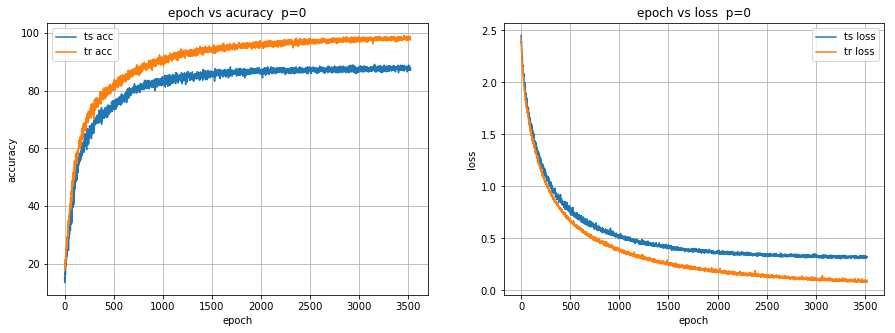

In [19]:
train = 0
test  = 1
acc   = 0
loss  = 1

# epochs = len(s1)
# x1 = np.linspace(0,epochs,epochs)
x = np.linspace(0,epoch,epoch)
x1=x
for i in range(len(drop_prob_list)):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    ts_a = test_file[:epoch,test,acc]
    ts_l = test_file[:epoch,test,loss]
    tr_a = test_file[:epoch,train,acc]
    tr_l = test_file[:epoch,train,loss]
#     ts_a = s1[:,test,acc]
#     ts_l = s1[:,test,loss]
#     tr_a = s1[:,train,acc]
#     tr_l = s1[:,train,loss]
    
    plt.plot(x1,ts_a,label='ts acc')
    plt.plot(x1,tr_a,label='tr acc')
    plt.title('epoch vs acuracy  p=' + str(drop_prob_list[i]))
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.plot(x1,ts_l,label='ts loss')
    plt.plot(x1,tr_l,label='tr loss')
    plt.title('epoch vs loss  p=' + str(drop_prob_list[i]))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    